/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 695us/step
‚úÖ RMSE : 2.0170196853827402
‚úÖ R¬≤ score : 0.2323514916956272


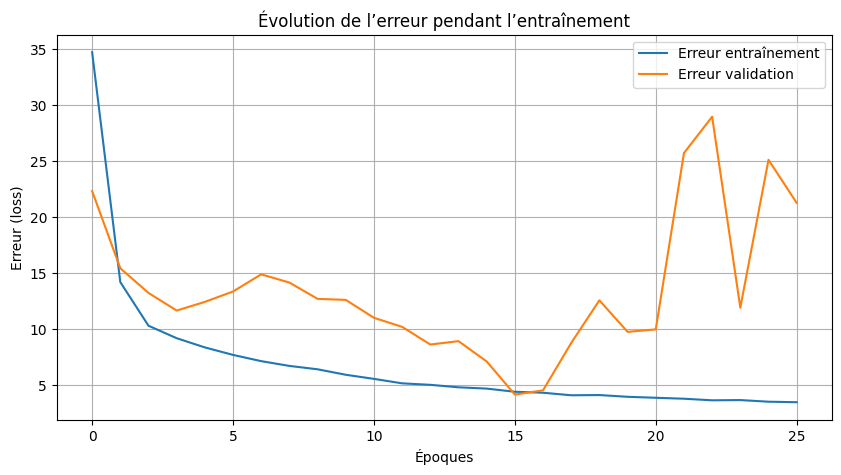

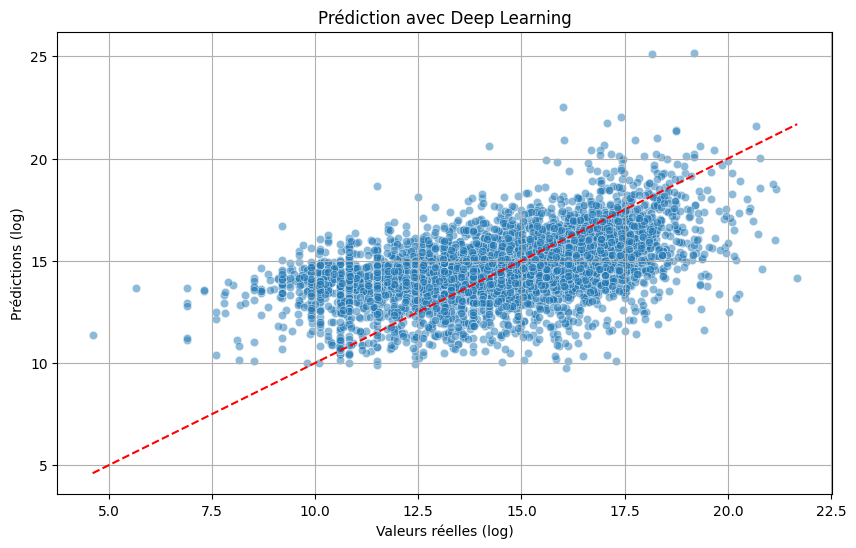

In [3]:
import pandas as pd # Manipulation de donn√©es tabulaires (exel,csv) sous forme de tableaux dataframes
import numpy as np  #calcul num√©rique rapides sur des tableaux (arrays)
import matplotlib.pyplot as plt #visualisation graphiques...
import seaborn as sns #faire des graphique s statistiques jolis et simple

from sklearn.model_selection import train_test_split #entrainer, tester et evaluer des modeles de ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf # construction et entrainement de r√©seaux de neurones profonds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Charge le dataset / constitution du dataframe / et suppression des espaces inutiles + passage en minuscule 
path = "/Users/amar/Desktop/Alyra_School/Alyra 2025/4- Projet/investments_VC.csv"

#------------
# NETTOYAGE ET PREPARATION DES DONNEES 
#------------

df = pd.read_csv(path, encoding='unicode_escape')
df.columns = df.columns.str.strip().str.lower()

# Colonnes utiles
cols = ['country_code', 'market', 'category_list', 'funding_rounds', 'founded_year', 'funding_total_usd']
df = df[cols]

# Nettoyage des montants
df['funding_total_usd'] = df['funding_total_usd'].replace(r'[\$,]', '', regex=True) # Suppression les caract√®res $ et , dans les montants
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')   # Conversion de la colonne en float. Les erreurs de conversion deviennent des NaN

# Nettoyage : suppression des NaN et des montants √† 0
df.dropna(inplace=True)                 # Suppression de toutes les lignes contenant des valeurs manquantes sur ces colonnes (country_code, market, category_list, funding_rounds, founded_year, funding_total_usd)
df = df[df['funding_total_usd'] > 0]    #suprresion des lignes avec des montants de financement nuls ou n√©gatifs.

# Transformation de la cible en log
df['log_funding'] = np.log1p(df['funding_total_usd'])   # on applique log1p (log(1+x) pour r√©duire les √©carts de valeurs extremes

# Encodage des variables cat√©gorielles  
# Drop(..): supprime les colonnes 'funding_total_usd' (montant r√©el--> version brut d√©j√† transform√©e), 'log_funding' (cible de la pr√©diction--> variable cible (y))
# pd.get.dummies(..., drop first=True) : transforme les colonnes cat√©gorielles(texte) en colonnes num√©riques grace √† l'encodage one-hot.
#suppression de la premi√®re modalit√© de chaque colonne encod√©e pour √©viter les redondance (multicolin√©arit√©) 
X = pd.get_dummies(df.drop(['funding_total_usd', 'log_funding'], axis=1), drop_first=True)

# Cible
y = df['log_funding']   #variable cible de l'apprentissage

# Split train/test (scikit-learn)
# X_train : les features utilis√©es pour entra√Æner le mod√®le
# X_test : les features utilis√©es pour tester le mod√®le
# y_train : les valeurs cibles correspondantes √† X_train
# y_test : les valeurs cibles correspondantes √† X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
# On cr√©e un objet StandardScaler de sklearn.
# Cet outil permet de standardiser les donn√©es, c‚Äôest-√†-dire de les transformer pour qu‚Äôelles aient :
# une moyenne (mean) de 0
# un √©cart-type (std) de 1
# -> Cela facilite l'entra√Ænement car les variables ont des ordres de grandeur comparables.


X_train_scaled = scaler.fit_transform(X_train)
# Calculer la moyenne et l‚Äô√©cart-type des colonnes de X_train (c‚Äôest le .fit())
# Appliquer la transformation (c‚Äôest le .transform())
# R√©sultat : chaque colonne de X_train_scaled est centr√©e r√©duite.

X_test_scaled = scaler.transform(X_test)
# On applique la m√™me transformation aux donn√©es de test X_test.
# on n‚Äôutilise pas .fit_transform() sur X_test, car on veut garder les m√™mes param√®tres (moyenne et √©cart-type) que ceux appris sur les donn√©es d'entra√Ænement.

# Attention : 
# fit() = apprend les statistiques (moyenne, √©cart-type)
# transform() = applique la transformation (x - ¬µ) / œÉ aux donn√©es

#-------------------
# Construction du modele de neurones en utilsant la bibliotheque Keras(Tensorflow)
#-------------------

# L‚Äôobjectif est de pr√©dire un montant (logarithm√©), donc la sortie est une valeur continue.
# Le modele est compos√© de 3 couches de neurones Denses, entrecoup√© de 2 couches de dropout (cach√©es) avec activation ReLU

# Il y a 2 couches  dense avec activation ReLU
# des couches Dropout pour √©viter le surapprentissage (Overfifting)
# une sortie avec 1 seule valeur
# une compilation avec l'optimiseur Adam et une fonction de perte MSE (erreur quadratique moyenne)

# Cr√©ation d‚Äôun mod√®le s√©quentiel, c‚Äôest-√†-dire un empilement de couches lin√©aires les unes apr√®s les autres.
model = Sequential()

# Ajout 1ere couche Dense (fully connected) de 128 neurones avec activation ReLU(Rectified Linear Unit) pour introduire de la non lin√©arit√©
# La fonction ReLU transforme une valeur en elle-m√™me si elle est positive, ou en 0 si elle est n√©gative.
# Elle permet au r√©seau de mieux apprendre des fonctions complexes tout en restant tr√®s efficace √† l'entra√Ænement.

# input_dim=X_train_scaled.shape[1] : dimension d‚Äôentr√©e = nombre de features (colonnes) dans X_train_scaled.

# ReLU(x)={ x si¬†x>0 (une¬†droite) Sinon =0 si x‚â§0(une¬†constante)

model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))

# Ajout d'une couche Dropout : pendant l'entrainement 30% des neurones sont d√©sactiv√©s al√©atoirement pour √©viter le surapprentissage(r√©gularisation)
model.add(Dropout(0.3))

# Cr√©ation de 2ieme couche Denses de 64 neurones + ReLU pour la non-lin√©arit√©
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))  # 1 seul neurone, pas de fonction d‚Äôactivation 

# Configuration du modele avant entrainement pour apprendre en minimisant l‚Äôerreur quadratique moyenne, √† l‚Äôaide de l‚Äôoptimiseur Adam.

# Ce modele dit comment le modele va apprendre (l'optimiseur) et ce qu'il doit minimiser (fonction de perte)
# Adam : algo d'optimisation -> il ajuste le taux d'apprentissage a chaque it√©ration (ajuste les poids pour r√©duire l'erreur : rapide, efficace, n√©cessite peu de r√©glages manuels)
    # Adam = Adaptive Moment Estimation : MAJ des poids du r√©seau (w) pendant l'apprentissage
        # Adam = Momentum + RMSProp
            # Momentum : il garde en m√©moire une moyenne des anciennes directions comme une inertie
            # RMSProp : Root Mean Square Propagation - adapte automatiquement la taille des pas pour chaque poids.
                # Le pas = quantit√© de changement appliqu√©e au poids du modele √† chaque mise √† jour. D√©termine a quelle vitesse le modele apprend.
                # il d√©pend du gradient : direction √† suivre pour r√©duire l'erreur
                # et du Learning rate : determine la taille du pas

# loss='mse -> Mean square error (erreur quadratique moyenne)= fonction de perte utilis√© pour les prb de r√©gression
    # --> calcul la moyenne des carr√©s de √©carts entre les pr√©dictions du modele et les vraies valeurs 
model.compile(optimizer='adam', loss='mse')

#-------------------
# Entrainement
#-------------------

# Entra√Ænement en utilisant les donn√©es d'entr√©es X_train_scaled et les cibles y_train
# X_train_scaled : les donn√©es d‚Äôentr√©e (features), d√©j√† normalis√©es. 
# y_train : les valeurs cibles qu‚Äôon veut pr√©dire.
# epochs=100 : Le mod√®le va parcourir toutes les donn√©es d'entra√Ænement 100 fois. Chaque passage complet sur l‚Äôensemble s‚Äôappelle une "√©poque".
# batch_size=32: les donn√©es sont divis√©es en petits groupes de 32 exemples.
# Cela r√©serve automatiquement 20% des donn√©es d‚Äôentra√Ænement pour valider le mod√®le √† chaque √©poque.
# verbose=0 : Mode silence 
#l'objet history contient l'√©volution des m√©trics √† chaque √©poque. 
# history.history['loss'] : erreur d'entra√Ænement
# history.history['val_loss'] : erreur de validation

# D√®s que val_loss cesse de s'am√©liorer pendant 10 √©poques cons√©cutives,
# le training s'arr√™te automatiquement, et les meilleurs poids sont restaur√©s.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop],verbose=0)

#-------------------
# Pr√©diction
#-------------------
# on lance la pr√©diction y_pred avec X_test_scaled valeur nouvelle
y_pred = model.predict(X_test_scaled)


#-------------------
# √âvaluation
#-------------------

# On √©value l‚Äôerreur entre la v√©rit√© (y_test) et ce que le mod√®le a pr√©dit (y_pred).
# mean_squared_error() = moyenne des carr√©s des √©carts ‚Üí mesure l‚Äôerreur moyenne.
#L'erreur moyenne est de 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# arrive √† pr√©dire 29,8% des fluctuations
r2 = r2_score(y_test, y_pred)

print(f"‚úÖ RMSE : {rmse}")
print(f"‚úÖ R¬≤ score : {r2}")

# üîπ Visualisation

# Tracer la courbe de perte (training vs validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Erreur entra√Ænement')
plt.plot(history.history['val_loss'], label='Erreur validation')
plt.xlabel('√âpoques')
plt.ylabel('Erreur (loss)')
plt.title('√âvolution de l‚Äôerreur pendant l‚Äôentra√Ænement')
plt.legend()
plt.grid(True)
plt.show()

#Avec 100 epoques 
# üîµ Erreur entra√Ænement (ligne bleue) :
# Elle diminue r√©guli√®rement et reste tr√®s basse.
# Le mod√®le apprend tr√®s bien les donn√©es d‚Äôentra√Ænement.

# üü† Erreur validation (ligne orange) :
# Elle commence correctement (basse au d√©part), puis :
# Elle explose √† partir d‚Äôenviron 15-20 √©poques, avec de fortes variations (instabilit√©).
# Le mod√®le n‚Äôarrive plus √† g√©n√©raliser.
# Il est clairement en overfitting.
#>>> Ajout d'un early stop

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.5) # x-> valeur r√©elles et y-> valeurs pr√©dites
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valeurs r√©elles (log)")
plt.ylabel("Pr√©dictions (log)")
plt.title("Pr√©diction avec Deep Learning")
plt.grid(True)
plt.show()
